# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [2]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car (수용와 공급 법칙에 의해 수량이 많을 수록 저렴할 것, 브랜드 가치에 영향을 받을 것)
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model. 
(중고차 가격은 연식에 영향을 많이 받음)

* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
(운전 거리도 주요한 지표가 될 것으로 예상)

* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
(연비 또한 가격에 주요한 영향 미침)

* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
(배기량과 마력이 큰 차가 비쌈)

* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.
(신차가격의 단위가 달라 통합 필요 -> 1 Cr = 100 Lakh)


In [3]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


### Data preprocessing

In [4]:
data.drop('Unnamed: 0',inplace = True, axis = 1)
data.info()
data.isnull().sum()
# mileage, Engine, Power, New price에 결측값이 있으며 단위로 인해 숫자형이 아닌 문자형으로 인식되고 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [366]:
#단위 제거(빈칸으로 변경)
# data['Mileage'] = data['Mileage'].replace(" km/kg","") 의 경우 단위를 없애지 못함
data['Mileage'] = data['Mileage'].str.replace(" km/kg","")
data['Mileage'] = data['Mileage'].str.replace(" kmpl","")
data['Engine'] = data['Engine'].str.replace(" CC"," ")
data['Power'] = data['Power'].str.replace(" bhp"," ")
#power collum에 null 과 빈칸 제거
data['Power'] = data['Power'].apply(lambda x : np.nan if x == 'null ' else x if  " " else x)
data.head()


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6,998,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.2,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2,1199,88.7,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2,1968,140.8,5.0,NaN,17.74


In [367]:
#수치형 변수로 변환
data['Mileage'] = pd.to_numeric(data.Mileage)
data['Engine'] = pd.to_numeric(data.Engine)
data['Power'] = pd.to_numeric(data.Power)
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 611.4+ KB


Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                 143
Seats                  42
New_Price            5195
Price                   0
dtype: int64

## EDA

In [368]:
# Name 을 Brand와 Model 로 나누어 각 Brand와 Model 별로 평균 가격 내림차순 정리
data["Brand"] = data.Name.map(lambda x : x.split()[0])
data["Model"] = data.Name.map(lambda x : x.split()[1:])
data.groupby('Brand').mean().sort_values('Price',ascending = False)

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
Brand,,,,,,,
Lamborghini,2011.000000,6500.000000,6.400000,5204.000000,560.000000,2.000000,120.000000
Bentley,2006.000000,48000.000000,8.600000,5998.000000,552.000000,4.000000,59.000000
Porsche,2013.222222,40046.777778,13.515556,3479.666667,331.287500,4.055556,48.348333
Land,2014.016667,59869.016667,10.959167,2475.719298,189.602105,5.403509,39.259500
Jaguar,2014.400000,36380.725000,14.955750,2623.150000,239.075250,4.850000,37.632250
Mini,2015.076923,24890.307692,18.593846,1766.615385,147.438462,4.423077,26.896923
Mercedes-Benz,2013.550314,48766.745283,13.891761,2372.254717,193.579873,5.044025,26.809874
Audi,2013.614407,53184.885593,15.171780,2281.758475,192.106043,5.262712,25.537712
BMW,2013.056180,79489.363296,16.989700,2323.221374,209.819847,4.954198,25.243146


In [369]:
data.groupby('Name').mean().sort_values('Price',ascending = False)

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
Name,,,,,,,
Land Rover Range Rover 3.0 Diesel LWB Vogue,2017.0,25000.0,13.33,2993.0,255.0,5.0,160.000
Lamborghini Gallardo Coupe,2011.0,6500.0,6.40,5204.0,560.0,2.0,120.000
Jaguar F Type 5.0 V8 S,2015.0,8000.0,12.50,5000.0,488.1,2.0,100.000
BMW 7 Series 740Li,2017.5,22762.5,12.05,2979.0,320.0,5.0,93.335
Mercedes-Benz SLK-Class 55 AMG,2014.0,3000.0,12.00,5461.0,421.0,2.0,90.000
...,...,...,...,...,...,...,...
Tata New Safari DICOR 2.2 VX 4x2,2008.0,86000.0,13.93,2179.0,138.0,7.0,0.600
Fiat Siena 1.2 ELX,2001.0,70000.0,0.00,1242.0,NaN,5.0,0.550
Tata Nano STD SE,2012.0,80000.0,25.40,624.0,37.5,4.0,0.530


In [370]:
print("Brand 별 자동차의 대수 : \n",data["Brand"].value_counts())
print("Model 별 자동차의 대수 : \n",data["Model"].value_counts())

# Model collum이 1876 개로 Brand collum 이용
data.drop('Model',inplace = True, axis =1)
data.drop('Name',inplace = True, axis =1)

Brand 별 자동차의 대수 : 
 Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Smart               1
Ambassador          1
Isuzu               1
Bentley             1
Lamborghini         1
Name: Brand, dtype: int64
Model 별 자동차의 대수 : 
 [XUV500, W8, 2WD]                49
[Swift, VDI]                     45
[City, 1.5, S, MT]               34
[Swift, Dzire, VDI]              34
[Swift, VDI, BSIV]               31
                                 ..
[Fiesta, Titanium, 1.5, TDCi]     1


In [371]:
print("Year 별 자동차의 대수 : \n",data["Year"].value_counts())
data.groupby('Year').mean().sort_values('Price')
# 연식이 짧을 수록 가격이 높아지는 경향 확인

Year 별 자동차의 대수 : 
 2014    797
2015    744
2016    741
2013    649
2017    587
2012    580
2011    466
2010    342
2018    298
2009    198
2008    174
2007    125
2019    102
2006     78
2005     57
2004     31
2003     17
2002     15
2001      8
2000      4
1998      4
1999      2
Name: Year, dtype: int64


,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
Year,,,,,,
1999,105000.000000,15.150000,1168.000000,75.000000,5.000000,0.835000
2000,112500.000000,15.267500,1817.000000,60.775000,5.750000,1.175000
2002,75354.066667,12.126667,1336.714286,61.372727,5.285714,1.294000
1998,87400.000000,14.900000,1188.000000,92.566667,5.000000,1.432500
2001,139742.875000,10.900000,1625.428571,86.950000,5.428571,1.543750
2004,103154.290323,12.483226,1525.413793,93.748000,5.448276,1.941290
2005,92942.245614,13.090351,1665.446429,105.446512,5.436364,2.026842
2003,81862.411765,14.670588,1466.066667,82.000000,5.133333,2.440000
2007,84852.496000,14.730800,1606.528455,104.295905,5.317073,3.204000


# 결측치 제거
회사 별 평균을 구하여 결측치 제거

In [372]:
# 0이 있다면 평균 계산에 영향을 주기 때문에 np.nan으로 대체
data.loc[data['Mileage'] == 0, 'Mileage'] = np.nan
data.loc[data['Engine'] == 0, 'Mileage'] = np.nan
data.loc[data['Power'] == 0, 'Mileage'] = np.nan
data.loc[data['Mileage'] == 0, 'Mileage'] = np.nan
data.loc[data['Seats'] == 0, 'Mileage'] = np.nan
data.drop('New_Price',inplace = True, axis = 1) #결측값이 대부분이기에 분석에 필요없다고 판단

In [373]:
data = data.groupby('Brand').apply(lambda x: x.fillna(x.mean()))
data.isnull().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              1
Engine               0
Power                1
Seats                0
Price                0
Brand                0
dtype: int64

In [374]:
data[data["Power"].isnull()] #Power 와 Mielage 모두 결측치임으로 제거해주었다.
data = data.dropna()
data.isnull().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
dtype: int64

# 분포 확인

In [375]:
data.describe() #변수 간 범위가 상이하여 스케일링 필요 -> log 변환

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,6018.000000,6.018000e+03,6018.000000,6018.000000,6018.000000,6018.000000,6018.000000
mean,2013.359089,5.873103e+04,18.328211,1621.013738,113.054212,5.278306,9.480545
std,3.269284,9.127464e+04,4.161960,600.718922,53.654051,0.805305,11.188535
min,1998.000000,1.710000e+02,6.400000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,15.290000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.200000,1493.000000,94.000000,5.000000,5.640000
75%,2016.000000,7.300000e+04,21.100000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000


In [376]:
data['log_Power'] = data['Power'].map(lambda x: np.log(x))
data['log_Engine'] = data['Engine'].map(lambda x: np.log(x))
data['log_Kilometers_Driven'] = data['Kilometers_Driven'].map(lambda x: np.log(x))
data['log_Mileage'] = data['Mileage'].map(lambda x: np.log(x))
data['log_Price'] = data['Price'].map(lambda x: np.log(x))
data.drop("Power",inplace=True,axis = 1)
data.drop("Engine",inplace=True,axis = 1)
data.drop("Kilometers_Driven",inplace=True,axis = 1)
data.drop("Mileage",inplace=True,axis = 1)
data.drop("Price",inplace=True,axis = 1)

<AxesSubplot:>

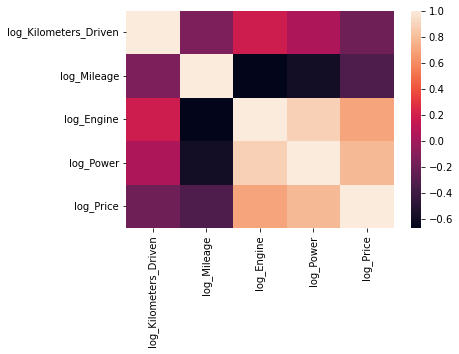

In [377]:
data.describe()
num_cols = ['log_Kilometers_Driven', 'log_Mileage', 'log_Engine', 'log_Power', 'log_Price']
sns.heatmap(data = data[num_cols].corr())

#### log_Power와 log_Engine 이 log_Price와 큰 상관관계를 보인다.

## Regression Model

In [386]:
data.info()
#범주형 변수 One_hot 인코딩
dummy_cols = ['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type','Seats','Brand']
dummy_data = data[dummy_cols]
dummy_data['Year'] = dummy_data.Year.astype('str')
dummy_data['Seats'] = dummy_data.Seats.astype('int').astype('str')
dummy_data = pd.get_dummies(dummy_data, prefix= dummy_cols)
dummy_data
num_cols = ['log_Power','log_Engine','log_Kilometers_Driven','log_Mileage','log_Price']
num_data = data[num_cols]

# 범주형 데이터와 수치형 데이터를 합침
train = pd.concat([dummy_data, num_data], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               6018 non-null   object 
 1   Year                   6018 non-null   int64  
 2   Fuel_Type              6018 non-null   object 
 3   Transmission           6018 non-null   object 
 4   Owner_Type             6018 non-null   object 
 5   Seats                  6018 non-null   float64
 6   Brand                  6018 non-null   object 
 7   log_Power              6018 non-null   float64
 8   log_Engine             6018 non-null   float64
 9   log_Kilometers_Driven  6018 non-null   float64
 10  log_Mileage            6018 non-null   float64
 11  log_Price              6018 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 611.2+ KB


In [393]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

target = train["log_Price"]
feature = train.drop(['log_Price'],axis = 1)
#데이터를 train 과 test로 분리
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=10)

In [394]:
feature

,Location_Ahmedabad,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,...,Brand_Renault,Brand_Skoda,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo,log_Power,log_Engine,log_Kilometers_Driven,log_Mileage
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,4.063198,6.905753,11.184421,3.280911
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.837868,7.366445,10.621327,2.979095
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.485260,7.089243,10.736397,2.901422
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.485936,7.129298,11.373663,3.033510
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,4.947340,7.584773,10.613246,2.721295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6014,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,4.304065,7.129298,10.217020,3.346389
6015,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,4.262680,7.021084,11.512925,3.194583
6016,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,4.718499,7.823246,10.915088,2.639057
6017,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,4.206184,6.905753,10.736397,2.939162


In [395]:
lr = LinearRegression()
lr.fit(x_train,y_train)
lr_pred_train = lr.predict(x_train)
lr_pred_test = lr.predict(x_test)

In [392]:
print(lr.intercept_)
print(lr.coef_)

-565623262596.3181
[ 4.93841330e+11  4.93841330e+11  4.93841330e+11  4.93841330e+11
  4.93841330e+11  4.93841330e+11  4.93841330e+11  4.93841330e+11
  4.93841330e+11  4.93841330e+11  4.93841330e+11 -1.17942143e+10
 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10
 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10
 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10
 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10
 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10 -1.17942143e+10
 -1.17942143e+10  1.22343020e+10  1.22343020e+10  1.22343020e+10
  1.22343020e+10  1.22343020e+10  7.61289511e+09  7.61289511e+09
  7.30591615e+10  7.30591615e+10  7.30591615e+10  7.30591615e+10
 -1.34889750e+10 -1.34889750e+10 -1.34889750e+10 -1.34889750e+10
 -1.34889750e+10 -1.34889750e+10 -1.34889750e+10 -1.34889750e+10
 -1.34889750e+10  4.15876317e+09  4.15876317e+09  4.15876317e+09
  4.15876317e+09  4.15876317e+09  4.15876317e+09  4.15876317e+09
  4.15

In [396]:
model_train = lr.predict(x_train)
model_test = lr.predict(x_test)

In [399]:
# R-squared
print('Linear Regression train R-squared: ',lr.score(x_train, y_train))
print('Linear Regression test R-squared : ',lr.score(x_test, y_test))

# MSE
print('Linear Regression train MSE      : ',mean_squared_error(y_train, lr_pred_train))
print('Linear Regression test MSE       : ',mean_squared_error(y_test, lr_pred_test))

Linear Regression train R-squared:  0.9392843197088265
Linear Regression test R-squared :  0.9343387750752155
Linear Regression train MSE      :  0.04609371865910337
Linear Regression test MSE       :  0.051343218422370704


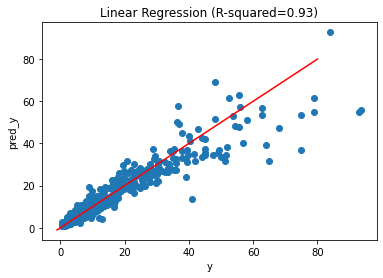

In [400]:
plt.scatter(np.exp(y_test), np.exp(lr_pred_test))
plt.plot([-1, 80], [-1, 80], 'r')
plt.xlabel('y')
plt.ylabel('pred_y')
plt.title('Linear Regression (R-squared=0.93)')
plt.show()

## Ridge Regression

In [403]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 10) # 10만큼의 규제적용 클수록 규제를 가하는 정도가 강해짐
ridge.fit(x_train, y_train)
ridge_pred_train = ridge.predict(x_train)
ridge_pred_test = ridge.predict(x_test)

In [406]:
intercept = ridge.intercept_
coef = ridge.coef_
print(intercept)
print(coef)

-3.1173134408747862
[ 0.01251597  0.13569958  0.02989885  0.14403728 -0.0711347   0.1335956
 -0.04370269  0.01808567 -0.24294933 -0.06983937 -0.04620686 -0.32464481
 -0.1577439  -0.15293427 -0.19715578 -0.42383426 -0.41255605 -0.46266203
 -0.61690764 -0.39566119 -0.32107855 -0.27349395 -0.17148948 -0.07485581
  0.04123695  0.17791058  0.29436142  0.39610126  0.50880079  0.5864015
  0.6626267   0.69781375  0.61976477 -0.0529312   0.09342608  0.0951683
 -0.01234776 -0.12331542  0.07412042 -0.07412042  0.08466107 -0.00535129
  0.01066085 -0.08997063 -0.00882743 -0.00682277  0.11805275  0.01229796
 -0.12958197 -0.00771205  0.01144099  0.02693461 -0.01578209  0.0123457
  0.33326131  0.30410177  0.06896538 -0.4111857  -0.22453328 -0.25554118
 -0.02053792 -0.18527798 -0.16527316 -0.13603179 -0.07163168 -0.02350413
  0.29257836  0.04118645  0.09810749  0.59241318 -0.33132652 -0.07661588
  0.39013053  0.45402757  0.01669333 -0.1394507   0.2022965  -0.12780458
 -0.13758931 -0.49616689  0.0400048

In [408]:
# R-squared
print('Ridge train R-squared: ',ridge.score(x_train, y_train))
print('Ridge test R-squared : ',ridge.score(x_test, y_test))
# MSE
print('Ridge train MSE      : ',mean_squared_error(y_train, ridge_pred_train))
print('Ridge test MSE       : ',mean_squared_error(y_test, ridge_pred_test))

Ridge train R-squared:  0.932177304856491
Ridge test R-squared :  0.9213769967487342
Ridge train MSE      :  0.05148917402645848
Ridge test MSE       :  0.06147856719969267


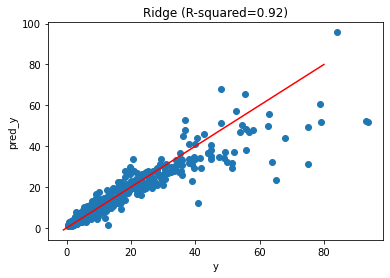

In [410]:
plt.scatter(np.exp(y_test), np.exp(ridge_pred_test))
plt.plot([-1, 80], [-1, 80], 'r')
plt.xlabel('y')
plt.ylabel('pred_y')
plt.title('Ridge (R-squared=0.92)')
plt.show()

## Lasso Regression

In [412]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 0.001)# 10만큼의 규제적용 클수록 규제를 가하는 정도가 강해짐
lasso.fit(x_train, y_train)
lasso_pred_train = lasso.predict(x_train)
lasso_pred_test = lasso.predict(x_test)

In [414]:
intercept = lasso.intercept_
coef = lasso.coef_
print(intercept)
print(coef)

-3.9296913511104212
[ 0.00000000e+00  1.14778441e-01  7.86156237e-03  1.25449707e-01
 -6.57950349e-02  1.25112867e-01 -3.79398083e-02  0.00000000e+00
 -2.41378569e-01 -7.24415892e-02 -4.81617625e-02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -2.79192677e-01
 -2.40904537e-01 -3.51885427e-01 -5.50383032e-01 -2.81447876e-01
 -2.07087214e-01 -1.57110457e-01 -5.86514825e-02  0.00000000e+00
  1.21620525e-01  2.62172718e-01  3.84151365e-01  4.87865757e-01
  6.04442188e-01  6.80676179e-01  7.61248037e-01  8.05860344e-01
  7.42395507e-01 -0.00000000e+00  1.10149579e-01  0.00000000e+00
  0.00000000e+00 -9.08112787e-02  1.47306451e-01 -0.00000000e+00
  7.29905269e-02 -0.00000000e+00  0.00000000e+00 -6.12582755e-02
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.49819940e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  4.00201240e-01  3.58958427e-01
  0.00000000e+00 -2.94429316e-01 -0.00000000e+00 -3.18742801e-02
 -0.0

In [415]:
# R-squared
print('Lasso train R-squared: ',lasso.score(x_train, y_train))
print('Lasso test R-squared : ',lasso.score(x_test, y_test))
# MSE
print('Lasso train MSE      : ',mean_squared_error(y_train, lasso_pred_train))
print('Lasso test MSE       : ',mean_squared_error(y_test, lasso_pred_test))

Lasso train R-squared:  0.9284673772406665
Lasso test R-squared :  0.9157952904629981
Lasso train MSE      :  0.05430565172957182
Lasso test MSE       :  0.06584313343077279


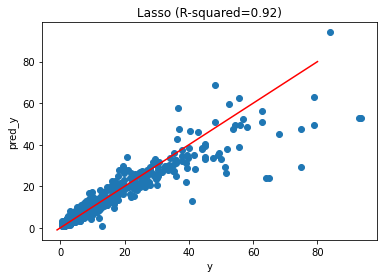

In [417]:
plt.scatter(np.exp(y_test), np.exp(lasso_pred_test))
plt.plot([-1, 80], [-1, 80], 'r')
plt.xlabel('y')
plt.ylabel('pred_y')
plt.title('Lasso (R-squared=0.92)')
plt.show()

In [419]:
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(alpha=0.01, l1_ratio=0.5)
elasticNet.fit(x_train, y_train)
elasticNet_pred_train = elasticNet.predict(x_train)
elasticNet_pred_test = elasticNet.predict(x_test)

In [420]:
intercept = elasticNet.intercept_
coef = elasticNet.coef_
print(intercept)
print(coef)

-2.0590395562868733
[ 0.          0.06716647 -0.          0.19268304 -0.          0.08982622
 -0.          0.07246218 -0.21161306 -0.04379395 -0.01000652 -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.15169919 -0.0632103  -0.12549505 -0.1416638  -0.10356521 -0.06595691
 -0.01568606  0.          0.09982425  0.18777722  0.28435145  0.31644237
  0.34557186  0.27642574  0.06424932  0.          0.14343481  0.
 -0.         -0.19529321  0.1474524  -0.14347136  0.13670107 -0.
 -0.         -0.          0.         -0.          0.          0.
 -0.09284249  0.          0.          0.         -0.         -0.
  0.10229567  0.04415135  0.         -0.12012608 -0.         -0.
 -0.         -0.         -0.03812467 -0.         -0.         -0.
  0.          0.          0.          0.12441115 -0.06673211  0.01956741
  0.19604298  0.          0.         -0.          0.          0.
 -0.         -0.17602269  0.10611059 -0.          0.          1.01423132
  0.20664124 -0.22916676  0.  

In [422]:
# R-squared
print('ElasticNet train R-squared: ',elasticNet.score(x_train, y_train))
print('ElasticNet test R-squared : ',elasticNet.score(x_test, y_test))
# MSE
print('ElasticNet train MSE      : ',mean_squared_error(y_train, elasticNet_pred_train))
print('ElasticNet test MSE       : ',mean_squared_error(y_test, elasticNet_pred_test))

ElasticNet train R-squared:  0.8713113996198807
ElasticNet test R-squared :  0.8596226733807053
ElasticNet train MSE      :  0.09769693944147946
ElasticNet test MSE       :  0.10976681824652347


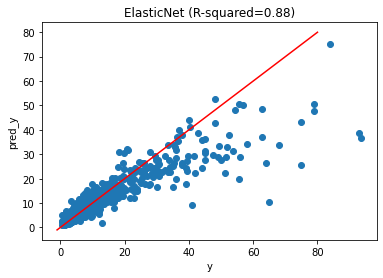

In [424]:
plt.scatter(np.exp(y_test), np.exp(elasticNet_pred_test))
plt.plot([-1, 80], [-1, 80], 'r')
plt.xlabel('y')
plt.ylabel('pred_y')
plt.title('ElasticNet (R-squared=0.88)')
plt.show()

## 모델 평가

|**모델의 종류**      |**R-squared**|**MSE**|
|:---------------------:|:---:|:---:|
|**Linear Regression**|0.9343|0.0513|
|**Ridge**            |0.9214|0.0615|
|**Lasso**            | 0.9158|0.0658|
|**ElasticNet**       |0.8596|0.1097|

Linear Regression, Ridge, Lasso, ElasticNet 순으로 모델의 성능이 좋다는 것을 확인할 수 있다.

# 회귀분석 가정 검토

## 설명변수와 종속변수 간 선형성

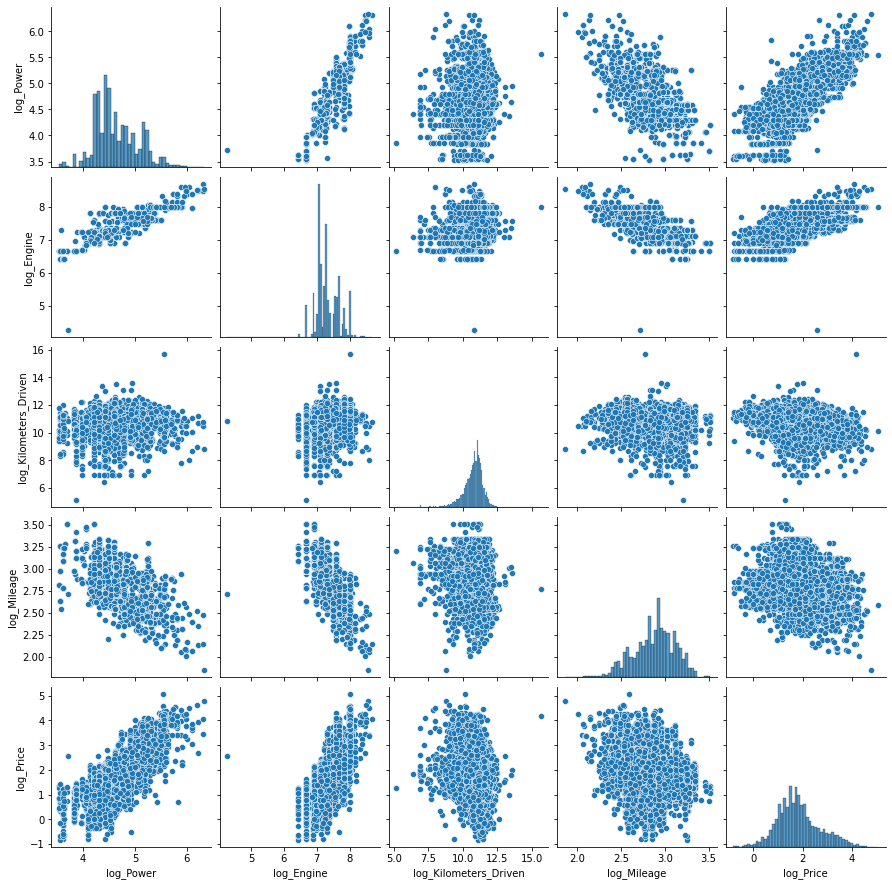

In [428]:
sns.pairplot(num_data)

설명변수와 종속변수 간 선형성을 판단한 결과 서로 선형성이 존재한다는 것을 확인할 수 있다.

## 잔차의 정규성

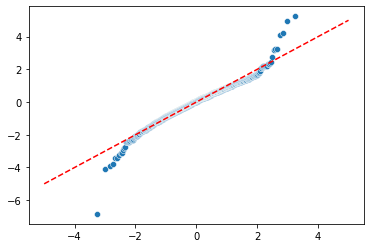

In [429]:
import scipy.stats

# 잔차 = 실제값 - 예측값 
residual = y_test - lr_pred_test

sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)

# 잔차의 정규성 
sns.scatterplot(x, y)
plt.plot([-5, 5], [-5, 5], '--', color='red')

잔차의 분포가 정규분포와 비슷한 형태이기 때문에 잔차의 정규성이 만족한다고 할 수 있다.

## 잔차의 등분산성

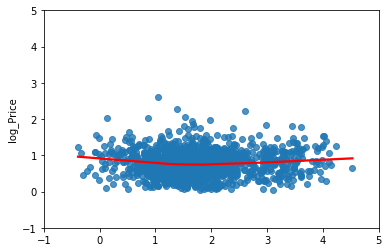

In [430]:
# 잔차의 등분산성 
sns.regplot(lr_pred_test, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})
plt.xlim(-1,5)
plt.ylim(-1,5)
plt.show()

모든 값들에 대하여 잔차의 분산이 동일하다는 가정하에 빨간 선이 수평에 가까운 것을 보아 잔차의 등분산성이 만족한다.

## 다중공선성

In [432]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 계산 모델
model = ols('log_Price ~ log_Kilometers_Driven + log_Mileage + log_Engine + log_Power',
            num_data)

res = model.fit()

pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept')

,컬럼,VIF
0,log_Kilometers_Driven,1.090969
1,log_Mileage,1.819446
2,log_Engine,5.672181
3,log_Power,4.742945


다중공선성의 문제를 가지는 변수 없음